In [48]:
# Dependencies and Setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import csv

In [49]:
pd.set_option('float_format', '{0:.2f}'.format)

In [50]:
zillow_df = pd.read_csv("OutputData - Total.csv")
zipcode_df = pd.read_csv("Files/manhattan_mod.csv")

In [51]:
zillow_df.columns

Index(['Unnamed: 0', 'address', 'rent', 'sold', 'sold year', 'sqft', 'var',
       'zipcode'],
      dtype='object')

In [52]:
zipcode_df.columns

Index(['Neighborhood', 'zipcode'], dtype='object')

In [53]:
zillow_df = zillow_df.drop(columns='Unnamed: 0', axis=1) # axis 0 for row and axis 1 for column
zillow_df.head()

,address,rent,sold,sold year,sqft,var,zipcode
0,189 E 7th St,nan,3300000.00,2015.00,4200.00,1,10009
1,189 E 7th St,14995.00,4844809.00,2018.00,2183.00,0,10009
2,189 E 7th St,14995.00,nan,nan,nan,2,10009
3,526 E 5th St,23000.00,6100000.00,2018.00,5200.00,0,10009
4,133 Avenue D APT 16,3995.00,nan,nan,nan,2,10009


In [54]:
zillow_df = pd.merge(zillow_df, zipcode_df, on="zipcode", how="outer")

In [55]:
zillow_df.count()

address         23736
rent            23588
sold            13408
sold year       13408
sqft            13408
var             23736
zipcode         23737
Neighborhood    23604
dtype: int64

In [56]:
rent_df = zillow_df.groupby("Neighborhood", as_index=False).median()
rent_df.columns

Index(['Neighborhood', 'rent', 'sold', 'sold year', 'sqft', 'var', 'zipcode'], dtype='object')

In [57]:
rent_df = rent_df.drop(columns=["sold","sold year","var", "sqft", "zipcode"], axis=1)

In [58]:
rent_df

,Neighborhood,rent
0,Central Harlem,3100.00
1,Chelsea/Clinton,4550.00
2,East Harlem,3125.00
3,Gramercy/Murray,3500.00
4,Greenwich/Soho,6900.00
5,Inwood/Washington Heights,2350.00
6,Lower Eastside,3950.00
7,Lower Manhattan,4700.00
8,Upper Eastside,3750.00
9,Upper Westside,3850.00


In [37]:
zillow_df = zillow_df[zillow_df.loc[:,"sold year"] == 2018]

In [38]:
zillow_df

,address,rent,sold,sold year,sqft,var,zipcode,Neighborhood
1,189 E 7th St,14995.00,4844809.00,2018.00,2183.00,0.00,10009,Lower Eastside
3,526 E 5th St,23000.00,6100000.00,2018.00,5200.00,0.00,10009,Lower Eastside
26,203 E 7th St,20000.00,6250000.00,2018.00,5446.00,0.00,10009,Lower Eastside
48,317 E 10th St,3795.00,5850000.00,2018.00,1000.00,0.00,10009,Lower Eastside
71,311 E 3rd St APT 20,2599.00,385000.00,2018.00,400.00,0.00,10009,Lower Eastside
72,311 E 3rd St APT 20,2673.00,385000.00,2018.00,400.00,0.00,10009,Lower Eastside
75,414 E 10th St APT 1D,2782.00,455000.00,2018.00,500.00,0.00,10009,Lower Eastside
76,412-414 E 10th St APT 2D,2782.00,492500.00,2018.00,500.00,0.00,10009,Lower Eastside
77,414 E 10th St APT 5A,3000.00,479500.00,2018.00,575.00,0.00,10009,Lower Eastside
79,216 E 7th St APT 8,3000.00,699000.00,2018.00,600.00,0.00,10009,Lower Eastside


In [59]:
zillow_df = zillow_df.dropna(how="any")

In [60]:
zillow_df.count()

address         13197
rent            13197
sold            13197
sold year       13197
sqft            13197
var             13197
zipcode         13197
Neighborhood    13197
dtype: int64

In [61]:
zillow_df = zillow_df.groupby("Neighborhood", as_index=False).median()

In [62]:
sold_df = zillow_df[["Neighborhood","sold", "sqft"]]

In [63]:
sold_df["Avg 20% Downpayment"] = sold_df["sold"]*.2

sold_df["Avg High Closing Cost"] = sold_df["sold"]*.05
sold_df["Avg Property Taxes"] = sold_df["sold"]*.008
avg_property_insurance = 1595

year1 = 15 *12
year2 = 30 *12
interestRate1 = 3.95/100/12
interestRate2 = 4.5/100/12

sold_df["15 Years Monthly Mortgage"] = (sold_df["sold"] * .8) * (interestRate1 * (1 +interestRate1) 
                                                                 ** year1) / ((1+interestRate1) ** year1 - 1)
sold_df["30 Years Monthly Mortgage"] = (sold_df["sold"] * .8) * (interestRate2 * (1 +interestRate2) 
                                                                 ** year2) / ((1+interestRate2) ** year2 - 1)
#Variable is the maintenance cost



C:\Users\yuj\anaconda\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\yuj\anaconda\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\yuj\anaconda\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set 

In [64]:
clean_df = pd.merge(sold_df, rent_df, on="Neighborhood", how="outer")

In [65]:
clean_df

,Neighborhood,sold,sqft,Avg 20% Downpayment,Avg High Closing Cost,Avg Property Taxes,15 Years Monthly Mortgage,30 Years Monthly Mortgage,rent
0,Central Harlem,670000.00,1039.00,134000.00,33500.00,5360.00,3951.31,2715.83,3100.00
1,Chelsea/Clinton,1200000.00,1050.00,240000.00,60000.00,9600.00,7076.97,4864.18,4550.00
2,East Harlem,539672.00,841.00,107934.40,26983.60,4317.38,3182.70,2187.55,3125.00
3,Gramercy/Murray,821250.00,855.00,164250.00,41062.50,6570.00,4843.30,3328.92,3500.00
4,Greenwich/Soho,1780919.00,1400.00,356183.80,89045.95,14247.35,10502.93,7218.92,6900.00
5,Inwood/Washington Heights,499000.00,900.00,99800.00,24950.00,3992.00,2942.84,2022.69,2350.00
6,Lower Eastside,895000.00,875.00,179000.00,44750.00,7160.00,5278.24,3627.87,3950.00
7,Lower Manhattan,975000.00,1058.00,195000.00,48750.00,7800.00,5750.04,3952.15,4700.00
8,Upper Eastside,950000.00,1059.00,190000.00,47500.00,7600.00,5602.60,3850.81,3750.00
9,Upper Westside,897000.00,1000.00,179400.00,44850.00,7176.00,5290.04,3635.97,3850.00


In [66]:
clean_df["Annual Cap Rate"] = ((clean_df["rent"]*12-clean_df["Avg Property Taxes"])/
                               (clean_df["sold"]+clean_df["Avg High Closing Cost"]))*100
clean_df["Cash on Cash Return"] = (((clean_df["rent"]-clean_df["30 Years Monthly Mortgage"])*12)/
(clean_df["Avg 20% Downpayment"]+clean_df["Avg High Closing Cost"]))*100


In [67]:
clean_df

,Neighborhood,sold,sqft,Avg 20% Downpayment,Avg High Closing Cost,Avg Property Taxes,15 Years Monthly Mortgage,30 Years Monthly Mortgage,rent,Annual Cap Rate,Cash on Cash Return
0,Central Harlem,670000.00,1039.00,134000.00,33500.00,5360.00,3951.31,2715.83,3100.00,4.53,2.75
1,Chelsea/Clinton,1200000.00,1050.00,240000.00,60000.00,9600.00,7076.97,4864.18,4550.00,3.57,-1.26
2,East Harlem,539672.00,841.00,107934.40,26983.60,4317.38,3182.70,2187.55,3125.00,5.86,8.34
3,Gramercy/Murray,821250.00,855.00,164250.00,41062.50,6570.00,4843.30,3328.92,3500.00,4.11,1.00
4,Greenwich/Soho,1780919.00,1400.00,356183.80,89045.95,14247.35,10502.93,7218.92,6900.00,3.67,-0.86
5,Inwood/Washington Heights,499000.00,900.00,99800.00,24950.00,3992.00,2942.84,2022.69,2350.00,4.62,3.15
6,Lower Eastside,895000.00,875.00,179000.00,44750.00,7160.00,5278.24,3627.87,3950.00,4.28,1.73
7,Lower Manhattan,975000.00,1058.00,195000.00,48750.00,7800.00,5750.04,3952.15,4700.00,4.75,3.68
8,Upper Eastside,950000.00,1059.00,190000.00,47500.00,7600.00,5602.60,3850.81,3750.00,3.75,-0.51
9,Upper Westside,897000.00,1000.00,179400.00,44850.00,7176.00,5290.04,3635.97,3850.00,4.14,1.15


In [47]:
clean_df

,Neighborhood,sold,sqft,Avg 20% Downpayment,Avg High Closing Cost,Avg Property Taxes,15 Years Monthly Mortgage,30 Years Monthly Mortgage,rent,Annual Cap Rate,Cash on Cash Return
0,Central Harlem,971993.50,1253.50,194398.70,48599.68,7775.95,5732.31,3939.96,3100.00,2.88,-4.15
1,Chelsea/Clinton,1100000.00,1039.00,220000.00,55000.00,8800.00,6487.23,4458.83,4550.00,3.97,0.40
2,East Harlem,719000.00,1600.00,143800.00,35950.00,5752.00,4240.29,2914.45,3125.00,4.21,1.41
3,Gramercy/Murray,814000.00,900.00,162800.00,40700.00,6512.00,4800.55,3299.53,3500.00,4.15,1.18
4,Greenwich/Soho,2740000.00,1800.00,548000.00,137000.00,21920.00,16159.09,11106.54,6900.00,2.12,-7.37
5,Inwood/Washington Heights,587000.00,1000.00,117400.00,29350.00,4696.00,3461.82,2379.39,2350.00,3.81,-0.24
6,Lower Eastside,984000.00,875.00,196800.00,49200.00,7872.00,5803.12,3988.63,3950.00,3.83,-0.19
7,Lower Manhattan,1421212.50,1329.50,284242.50,71060.62,11369.70,8381.57,5760.86,4700.00,3.02,-3.58
8,Upper Eastside,975000.00,1150.00,195000.00,48750.00,7800.00,5750.04,3952.15,3750.00,3.63,-1.00
9,Upper Westside,1050000.00,1127.00,210000.00,52500.00,8400.00,6192.35,4256.16,3850.00,3.43,-1.86


In [22]:
clean_df

,Neighborhood,sold,sqft,Avg 20% Downpayment,Avg High Closing Cost,Avg Property Taxes,15 Years Monthly Mortgage,30 Years Monthly Mortgage,rent,Annual Cap Rate,Cash on Cash Return
0,Central Harlem,945000.00,1168.50,189000.00,47250.00,7560.00,5573.12,3830.54,3100.00,2.99,-3.71
1,Chelsea/Clinton,1508000.00,1065.00,301600.00,75400.00,12064.00,8893.40,6112.65,4550.00,2.69,-4.97
2,East Harlem,684750.00,1017.00,136950.00,34237.50,5478.00,4038.30,2775.62,3125.00,4.45,2.45
3,Gramercy/Murray,882000.00,884.00,176400.00,44100.00,7056.00,5201.58,3575.17,3500.00,3.77,-0.41
4,Greenwich/Soho,2750000.00,1621.50,550000.00,137500.00,22000.00,16218.07,11147.08,6900.00,2.11,-7.41
5,Inwood/Washington Heights,565000.00,945.00,113000.00,28250.00,4520.00,3332.08,2290.22,2350.00,3.99,0.51
6,Lower Eastside,1170000.00,950.00,234000.00,58500.00,9360.00,6900.05,4742.57,3950.00,3.10,-3.25
7,Lower Manhattan,1342500.00,1174.00,268500.00,67125.00,10740.00,7917.36,5441.80,4700.00,3.24,-2.65
8,Upper Eastside,993000.00,1063.00,198600.00,49650.00,7944.00,5856.20,4025.11,3750.00,3.55,-1.33
9,Upper Westside,1140000.00,1100.00,228000.00,57000.00,9120.00,6723.13,4620.97,3850.00,3.10,-3.25


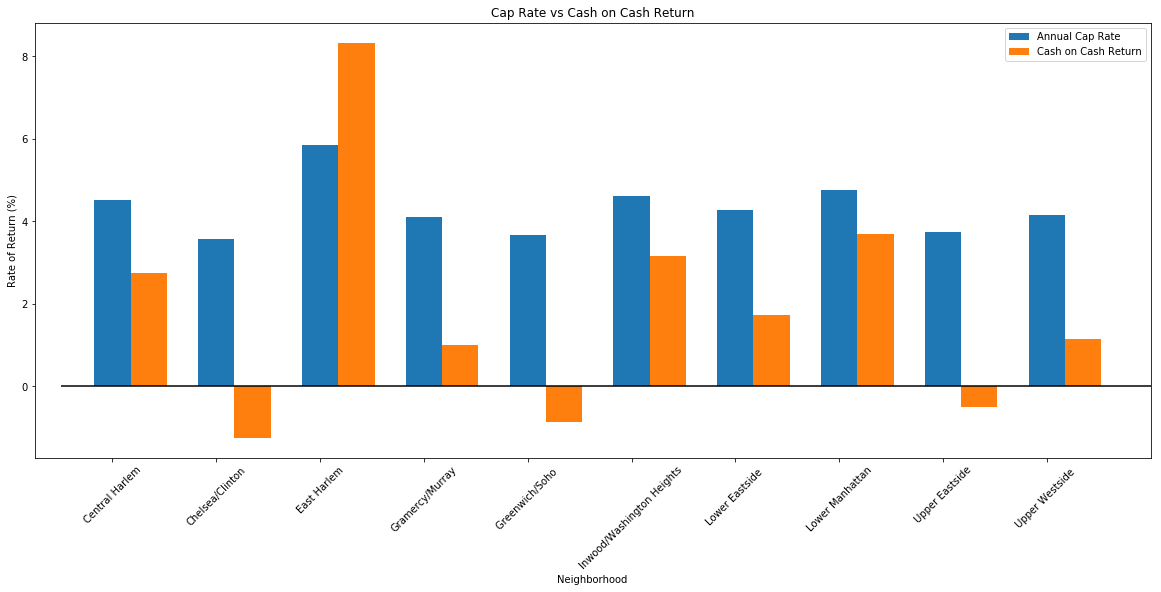

In [77]:
x_axis = np.arange(len(clean_df['Neighborhood']))
tick_locations = [value for value in x_axis]
plt.figure(figsize=(20,8))

bar_width = 0.35

plt.bar(x_axis, clean_df['Annual Cap Rate'], bar_width, label="Annual Cap Rate")

plt.bar(x_axis+bar_width, clean_df['Cash on Cash Return'], bar_width, label="Cash on Cash Return")

plt.xticks(tick_locations, clean_df['Neighborhood'], rotation="45")
plt.xlim(-0.75, len(x_axis))

plt.hlines(y = 0, xmin = -0.5, xmax = 10)

plt.title("Cap Rate vs Cash on Cash Return")
plt.xlabel("Neighborhood")
plt.ylabel(f"Rate of Return (%)")

plt.legend()

plt.savefig('CapRate_CoCReturn.png')
plt.show()

In [ ]:
clean_df.to_csv("RentvsMortgage.csv")

In [ ]:
x_axis = np.arange(len(clean_df['Neighborhood']))
tick_locations = [value for value in x_axis]
plt.figure(figsize=(20,5))

bar_width = 0.25

plt.bar(x_axis, clean_df['rent'], bar_width, color="black", label="Rent")
plt.bar(x_axis+bar_width, clean_df['15 Years Monthly Mortgage'], bar_width, color="blue", label="15 Years Monthly Mortgage")
plt.bar(x_axis+bar_width, clean_df['Avg 20% Downpayment']/year1, bar_width, color="brown",
        bottom=clean_df['15 Years Monthly Mortgage'], label="Avg 20% Downpayment over 15 Years")
plt.bar(x_axis+bar_width, clean_df['Avg Property Taxes'], bar_width, color="green",
        bottom=clean_df['Avg 20% Downpayment']/year1+clean_df['15 Years Monthly Mortgage'], label="Avg Property Taxes")

plt.bar(x_axis+bar_width*2, clean_df['30 Years Monthly Mortgage'], bar_width, color="red", label="30 Years Monthly Mortgage")
plt.bar(x_axis+bar_width*2, clean_df['Avg 20% Downpayment']/year2, bar_width, color="brown",
        bottom=clean_df['30 Years Monthly Mortgage'], label="Avg 20% Downpayment over 30 Years")
plt.bar(x_axis+bar_width*2, clean_df['Avg Property Taxes'], bar_width, color="green",
        bottom=clean_df['Avg 20% Downpayment']/year2+clean_df['30 Years Monthly Mortgage'])

plt.xticks(tick_locations, clean_df['Neighborhood'], rotation="vertical")
plt.xlim(-0.75, len(x_axis))

plt.title("Rent vs Purchase")
plt.xlabel("Neighborhood")
plt.ylabel(f"Average Monthly cost ($)")

plt.legend()

plt.show()

In [ ]:
clean_df.columns